In [1]:
from __future__ import print_function

from IPython import display

import math
import matplotlib
import sklearn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from numpy import radians, cos, sin, arcsin, arccos, sqrt, pi, arctan2, degrees, arctan

from tqdm import tqdm, tqdm_notebook
tqdm.pandas()
tqdm.pandas(tqdm_notebook)

from joblib import dump, load

from natsort import natsorted
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans


pd.options.display.max_rows = 10

In [2]:

def haversine(lat1, lon1, lat2, lon2):
    #ensure using numpy and not math, or pandas series cannot be passed
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a))
    r = 6378.137 ##radius of earth km
    return c * r

def compute_dist(df):
    next_df = df.shift(1)
    dist = haversine(df.iloc[:,0], df.iloc[:,1],
                    next_df.iloc[:,0], next_df.iloc[:,1])
    return dist

def compute_time(df):
    next_df = df.shift(1)
#     df["time"] = pd.to_datetime(df["time_utc"], format="%Y-%m-%d %H:%M:%S.%f", errors='raise')
    timedelt = df["time"] - next_df["time"]
    return timedelt

def compute_speed(df):
    kinematics = df.copy()
    kinematics["distance_travelled"] = compute_dist(kinematics[["latitude", "longitude"]].astype(float)).values
    kinematics["time_elapsed"] = compute_time(kinematics).values
    kinematics["time_elapsed_seconds"] = kinematics["time_elapsed"]/np.timedelta64(1,'s')
    kinematics["speed m/s"] = (kinematics["distance_travelled"]*1000)/kinematics["time_elapsed_seconds"]
    kinematics["speed kmh"] = kinematics["speed m/s"]*3.6
    kinematics["bearing"] = compute_bearing(kinematics[["latitude", "longitude"]].astype(float))
    kinematics['bearing_diff'] = compute_bearing_diff(kinematics)
    kinematics["rate_of_turn"] = kinematics["bearing_diff"]/kinematics["time_elapsed_seconds"]
    kinematics["acceleration"] = (speed_diff(kinematics["speed m/s"])) /kinematics["time_elapsed_seconds"]
    kinematics.drop(columns = ['time_elapsed'], inplace = True)
    kinematics.fillna(0, inplace = True)
#     df["distance_travelled"] = kinematics["distance_travelled"].values
#     df["speed kmh"] = kinematics["speed kmh"].values
    return kinematics

def compute_bearing(df):
    next_df = df.shift(1)
    bear = cal_bearing(df.iloc[:,0], df.iloc[:,1],
                    next_df.iloc[:,0], next_df.iloc[:,1])
    return bear

def bearing_diff(bearing, prev_bearing):
    
    """
    Calculates the absolute difference between two angles
    Parameters
      bearing: bearing in degrees of the first angle
      prev_bearing: bearing in degrees of the second angle
    Returns the difference in degrees as a float
    """

    # if bearing - prev_bearing <=180 then taking the absolute difference is correct
    if bearing - prev_bearing <= 180:
        bearing_diff = abs(bearing - prev_bearing)
    # otherwise if bearing is larger than previous_bearing the total difference is the prev_bearing plus the difference
    # between 360 and the bearing
    elif bearing > prev_bearing:
        bearing_diff = prev_bearing + (360 - bearing)
    # otherwise if prev_bearing is larger than bearing the total difference is the bearing plus the difference 
    # between 360 and the prev_bearing
    elif prev_bearing > bearing:
        bearing_diff = bearing + (360 - prev_bearing)
    # in all other cases take the absolute difference
    else:
        bearing_diff = abs(bearing - prev_bearing)

    return bearing_diff

def cal_bearing(lat1, lon1, lat2, lon2):
    """
    Calculates the bearing between two points using the formula
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    """
    
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    dlon = lon2 - lon1

    x = sin(dlon) * cos(lat2)
    y1 = cos(lat1) * sin(lat2)
    y2 = sin(lat1) * cos(lat2) * cos(dlon)
    y = y1 - y2

    initial_bearing = arctan2(x, y)

    initial_bearing = degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

def compute_bearing_diff(df):
    df1 = df.copy()
    df1["prev_bearing"] = df1["bearing"].shift(1)
    df1["bearing diff"] = df1.apply(lambda row: bearing_diff(row['bearing'],row['prev_bearing']),axis=1)
    return df1["bearing diff"]

def speed_diff(df):
    next_df = df.shift(1)
    diff = df - next_df
    return diff

def compute_speed(df):
    kinematics = df.copy()
    kinematics["distance_travelled"] = compute_dist(kinematics[["latitude", "longitude"]].astype(float)).values
    kinematics["time_elapsed"] = compute_time(kinematics).values
    kinematics["time_elapsed_seconds"] = kinematics["time_elapsed"]/np.timedelta64(1,'s')
    kinematics["speed m/s"] = (kinematics["distance_travelled"]*1000)/kinematics["time_elapsed_seconds"]
    kinematics["speed kmh"] = kinematics["speed m/s"]*3.6
    kinematics["bearing"] = compute_bearing(kinematics[["latitude", "longitude"]].astype(float))
    kinematics['bearing_diff'] = compute_bearing_diff(kinematics)
    kinematics["rate_of_turn"] = kinematics["bearing_diff"]/kinematics["time_elapsed_seconds"]
    kinematics["acceleration"] = (speed_diff(kinematics["speed m/s"])) /kinematics["time_elapsed_seconds"]
    kinematics.drop(columns = ['time_elapsed'], inplace = True)
    kinematics.fillna(0, inplace = True)
#     df["distance_travelled"] = kinematics["distance_travelled"].values
#     df["speed kmh"] = kinematics["speed kmh"].values
    return kinematics

In [3]:
df =  pd.read_csv('/mnt/hgfs/FYP/porto_cleaned_100000.csv', parse_dates = ['time'])

In [4]:
grouper = df.groupby('ID')

In [5]:
a = []
b = []
c = []
for name, val in tqdm(grouper):
    idx_grper = val.groupby(val['Unnamed: 0'].diff().ne(1).cumsum())
    for name2, taxi in idx_grper:
        a.append(len(taxi))
        b.append(name)
        c.append(taxi)

100%|██████████| 427/427 [00:26<00:00, 17.81it/s]


In [8]:
val = df[df['ID'] == 20000496]

In [9]:
a = []
b = []
idx_grper = val.groupby(val['Unnamed: 0'].diff().ne(1).cumsum())
for name, taxi in idx_grper:
    a.append(taxi)
    b.append(len(taxi))

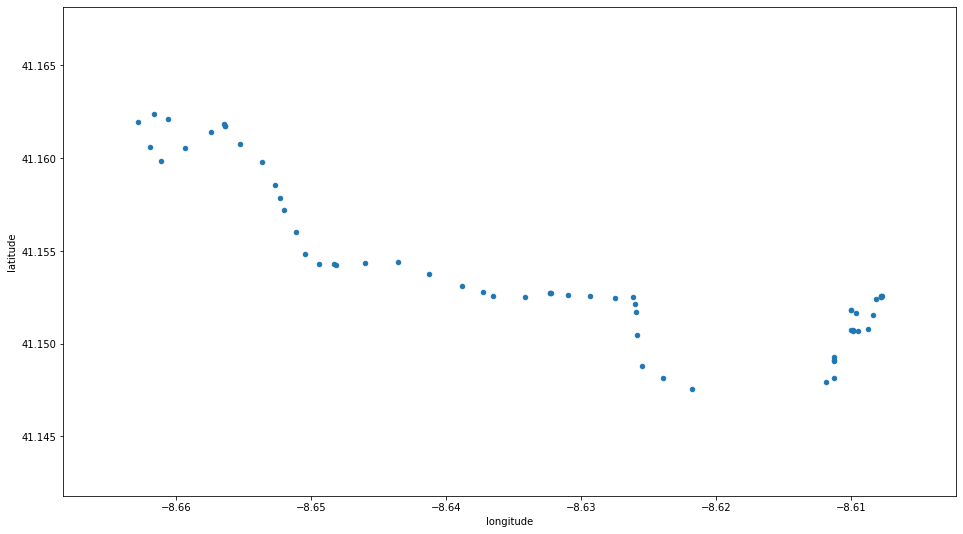

In [10]:
c[13].plot('longitude', 'latitude', kind = 'scatter', figsize = (16,9))

In [15]:
def time_to_dest(df):
    end_time = df['time'].iloc[-1]
    df['time_to_dest'] = (end_time - df['time']).dt.total_seconds().astype(int)
def set_dropoff(df):
    df['dropoff_latitude'] = df['latitude'].iloc[-1]
    df['dropoff_longitude'] = df['longitude'].iloc[-1]


In [20]:
import tensorflow as tf
from tensorflow.python.keras.backend import tanh, conv1d, expand_dims, squeeze, clip
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, Flatten, Conv1D, Conv2D, Lambda, concatenate, Reshape, TimeDistributed, MaxPooling1D, Permute, BatchNormalization, ELU
from tensorflow.python.keras.layers.recurrent import LSTM,RNN
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.python.keras import losses
# from tensorflow.python.keras.activations import elu


import tensorflow.python.keras.backend as K


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [21]:
from tensorflow.python.keras import backend as K
# import tensorflow as tf
def rmsle_K(y, y0):
    return K.sqrt(K.mean(K.square(tf.log1p(y) - tf.log1p(y0))))
def rmsletf(y_pred, y_true): 
    y_pred= tf.cast(y_pred, tf.float64) 
    y_true= tf.cast(y_true, tf.float64) 
    y_pred=tf.nn.relu(y_pred) 
    return np.abs(tf.sqrt(tf.reduce_mean(tf.squared_difference(tf.log1p(y_pred), tf.log1p(y_true)))))

In [37]:
from IPython.display import SVG
from tensorflow.python.keras.utils import model_to_dot

NameError: name 'model' is not defined

In [130]:
for i, d in enumerate(c):
    if len(d) < 40:
        c.pop(i)

In [ ]:
counter = 0
for i in c:
    i.plot('longitude', 'latitude', kind = 'scatter', figsize = (16,9))
    counter += 1
    if counter > 5:
        break

In [133]:
def coord_pca(taxi):
    coords = np.vstack((taxi[['pickup_latitude', 'pickup_longitude']].values,
                        taxi[['dropoff_latitude', 'dropoff_longitude']].values))
    pca = PCA()
    pca = pca.fit(coords)
    taxi['pickup_pca0'] = pca.transform(taxi[['pickup_latitude', 'pickup_longitude']])[:, 0]
    taxi['pickup_pca1'] = pca.transform(taxi[['pickup_latitude', 'pickup_longitude']])[:, 1]
    taxi['dropoff_pca0'] = pca.transform(taxi[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
    taxi['dropoff_pca1'] = pca.transform(taxi[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

In [38]:
km = KMeans(
    n_clusters=40, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
coordinates = pd.concat(c)[["longitude", "latitude"]].sample(10000).values
km.fit(coordinates)

In [39]:
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.latitude).abs()
    
    #the Haversine version
    foob = df[["latitude", "longitude","dropoff_latitude", "dropoff_longitude"]].astype(float)
    df['hav_dist_lat'] = haversine(foob.iloc[:,0], foob.iloc[:,1],foob.iloc[:,2],foob.iloc[:,1])
    df['hav_dist_lon'] = haversine(foob.iloc[:,2], foob.iloc[:,1],foob.iloc[:,2],foob.iloc[:,3])
    
    
def convert_km(df):
    df['abs_diff_longitude'] = df.abs_diff_longitude*80.4
    df['abs_diff_latitude'] = df.abs_diff_latitude*111

In [134]:
d = []
for i, df in (enumerate(c)):
    df2 = compute_speed(c[i])
    time_to_dest(df2)
    set_dropoff(df2)
    add_travel_vector_features(df2)
    convert_km(df2)
    df2['Euclidean'] = (df2.abs_diff_latitude**2 + df2.abs_diff_longitude**2)**0.5 
    
    df2['manh_length_hav'] = df2.hav_dist_lat + df2.hav_dist_lon
    df2['manh_length_euc'] = df2.abs_diff_latitude + df2.abs_diff_longitude
    
    df2['minkowski_0.9'] = (df2.hav_dist_lat**0.92 + df2.hav_dist_lon**0.92)**(1/0.92)
    df2['dist_to_dest'] = haversine(df2['latitude'].values, df2['longitude'].values, df2['dropoff_latitude'].values, df2['dropoff_longitude'].values)
    df2['pickup_weekday'] = df2['time'].dt.weekday
    df2['pickup_hour_weekofyear'] = df2['time'].dt.weekofyear
    df2['pickup_hour'] = df2['time'].dt.hour
    df2['pickup_minute'] = df2['time'].dt.minute
    df2['pickup_dt'] = (df2['time'] - df2['time'].min()).dt.total_seconds()
    df2['pickup_week_hour'] = df2['pickup_weekday'] * 24 + df2['pickup_hour']
    df2[['next_lat', 'next_lon']] = df2[['latitude', 'longitude']].shift(-5)
    
    coordinates = df2[['latitude', 'longitude']]
    pickup_km = km.predict(coordinates)
    df2["pickup_cluster"] = pickup_km
    
    coordinates = df2[['dropoff_latitude', 'dropoff_longitude']]
    dropoff_km = km.predict(coordinates)
    df2["dropoff_cluster"] = dropoff_km
    
    d.append(df2)
    if i > 3000:
        break

In [247]:
for i in d:
    i.dropna(inplace = True)

In [248]:
import random
random.shuffle(d)
mu, sigma = 0, 5

In [249]:
x_data = []
for i in d:
    x_data.append(i.drop(['Unnamed: 0', 'time', 'ID', 'time_elapsed_seconds', 'time_to_dest', 'next_lat', 'next_lon'] ,axis =1))
y_data = []
for i in d:
    noise = np.random.normal(mu, sigma, [len(i),1]) 
    y_data.append(i[['time_to_dest']] + abs(noise))
#     y_data.append(i[['next_lat', 'next_lon']])

In [250]:
y_data[1]

,time_to_dest
3285673,801.347380
3285674,780.808906
3285675,765.583055
3285676,754.953138
3285677,720.363113
...,...
3285708,240.971748
3285709,229.013290
3285710,222.366052
3285711,206.751128


In [251]:
x_data[1]

,longitude,latitude,distance_travelled,speed m/s,speed kmh,bearing,bearing_diff,rate_of_turn,acceleration,dropoff_latitude,...,minkowski_0.9,dist_to_dest,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour,pickup_cluster,dropoff_cluster
3285673,-8.620965,41.161059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,41.177763,...,6.016386,4.260669,2,29,13,5,0.0,61,24,24
3285674,-8.620983,41.161041,0.002508,0.167209,0.601952,36.974714,0.000000,0.000000,0.000000e+00,41.177763,...,6.017023,4.260187,2,29,13,5,15.0,61,24,24
3285675,-8.620956,41.161014,0.003762,0.250813,0.902928,323.025279,73.949435,4.929962,5.573634e-03,41.177763,...,6.022670,4.263537,2,29,13,5,30.0,61,24,24
3285676,-8.621037,41.160789,0.025951,1.730035,6.228127,15.164599,307.860681,20.524045,9.861479e-02,41.177763,...,6.043131,4.268468,2,29,13,6,45.0,61,24,24
3285677,-8.624484,41.160051,0.300344,10.011472,36.041299,74.124306,58.959708,1.965324,2.760479e-01,41.177763,...,5.832940,4.050861,2,29,13,6,75.0,61,24,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3285708,-8.662842,41.177907,0.001254,0.083597,0.300948,36.967632,107.752400,7.183493,-2.671548e-01,41.177763,...,0.346477,0.324651,2,29,13,14,555.0,61,24,24
3285709,-8.662851,41.177916,0.001254,0.083597,0.300948,143.032362,106.064730,7.070982,7.122497e-13,41.177763,...,0.346997,0.323949,2,29,13,14,570.0,61,24,24
3285710,-8.663265,41.177655,0.045248,3.016546,10.859565,50.050403,92.981959,6.198797,1.955299e-01,41.177763,...,0.305704,0.289064,2,29,13,15,585.0,61,24,24
3285711,-8.663652,41.177646,0.032441,2.162737,7.785854,88.230129,38.179726,2.545315,-5.692057e-02,41.177763,...,0.274405,0.256719,2,29,13,15,600.0,61,24,24


In [448]:
x_train = x_data[0:2900]
x_test = x_data[2900:]
y_train = y_data[0:2900]
y_test = y_data[2900:]

In [449]:
# sc = MinMaxScaler(feature_range=(-1,1))
scy = MinMaxScaler(feature_range=(-1,1))
# scy = sklearn.preprocessing.MaxAbsScaler()
sc = sklearn.preprocessing.RobustScaler()
# new_df= x_data[].reshape(x_data.shape[0],5)

sc.fit(pd.concat(x_train).values)
scy.fit(pd.concat(y_train).values)


MinMaxScaler(copy=True, feature_range=(-1, 1))

In [450]:
bad_idx = []
for i, data in enumerate(x_train):
    try:
        x_train[i] = sc.transform(data)
    except:
        bad_idx.append(i)
    
for i, data in enumerate(y_train):
    try:
        y_train[i] = scy.transform(data)
    except:
        pass

In [451]:
for i in bad_idx:
    x_train.pop(i)
    y_train.pop(i)

In [452]:
x_test = sc.transform(pd.concat(x_test).values)
y_test = scy.transform(pd.concat(y_test).values)
# y_test = pd.concat(y_test).values

In [453]:
x_train[1][12:15,0:2]

array([[-0.3022912 ,  0.2636775 ],
       [-0.34244888,  0.27231592],
       [-0.34318798,  0.27190457]])

In [52]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, 28)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, 1)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            j = np.random.randint(len(x_train))
            # Get a random start-index.
            # This points somewhere into the training-data.
            try:
                idx = np.random.randint(len(x_train[j]) - sequence_length)
            except:
                continue
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train[j][idx:idx+sequence_length]
            y_batch[i] = y_train[j][idx:idx+sequence_length]
#             x_batch[i] = x_train[j][0:sequence_length]
#             y_batch[i] = y_train[j][0:sequence_length]
        
        
        yield (x_batch, y_batch)

In [121]:
def batch_generator_multi_td(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        cnn_x_shape = (batch_size, sequence_length, 2)
        cnn_x_batch = np.zeros(shape=cnn_x_shape, dtype=np.float16)
        cnn_x_batch = cnn_x_batch.reshape(-1,2,sequence_length,1)
        aux_x_shape = (batch_size, sequence_length, 18)
        aux_x_batch = np.zeros(shape=aux_x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, 1)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            j = np.random.randint(len(x_train))
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(len(x_train[j]) - sequence_length)
            
            # Copy the sequences of data starting at this index.
            batchfiles = x_train[j][idx:idx+sequence_length, 0:2]
            cnn_x_batch[i] = batchfiles.reshape((2,sequence_length, -1))
            aux_x_batch[i] = x_train[j][idx:idx+sequence_length]
            y_batch[i] = y_train[j][idx:idx+sequence_length]
#             x_batch[i] = x_train[j][0:sequence_length]
#             y_batch[i] = y_train[j][0:sequence_length]
        
        
        yield [cnn_x_batch, aux_x_batch], y_batch

In [54]:
def batch_generator_multi(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        cnn_x_shape = (batch_size, sequence_length, 2)
        cnn_x_batch = np.zeros(shape=cnn_x_shape, dtype=np.float16)
        aux_x_shape = (batch_size, sequence_length, 26)
        aux_x_batch = np.zeros(shape=aux_x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, 1)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            j = np.random.randint(len(x_train))
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(len(x_train[j]) - sequence_length)
            
            # Copy the sequences of data starting at this index.

            cnn_x_batch[i] = x_train[j][idx:idx+sequence_length, 0:2]
            aux_x_batch[i] = x_train[j][idx:idx+sequence_length, 2:]
            y_batch[i] = y_train[j][idx:idx+sequence_length]
#             x_batch[i] = x_train[j][0:sequence_length]
#             y_batch[i] = y_train[j][0:sequence_length]
        
        
        yield [cnn_x_batch, aux_x_batch], y_batch

In [454]:
short_idx = []
for i, data in enumerate(x_train):
    if len(x_train[i]) < 40:
        short_idx.append(i)
x_train = [i for j, i in enumerate(x_train) if j not in short_idx]
y_train = [i for j, i in enumerate(y_train) if j not in short_idx]

In [455]:
x_len = []
for i, data in enumerate(x_train):
    x_len.append(len(x_train[i]))
    

(array([72., 79.,  0., 65.,  0., 74., 64.,  0., 65.,  0., 61., 51.,  0.,
        57.,  0., 55., 37.,  0., 47.,  0., 36.,  0., 48., 41.,  0., 36.,
         0., 32., 35.,  0., 36.,  0., 30., 18.,  0., 27.,  0., 22., 20.,
         0., 17.,  0., 19.,  0., 20., 17.,  0., 16.,  0., 15., 11.,  0.,
        16.,  0., 13., 18.,  0., 10.,  0.,  6.,  0.,  8., 12.,  0.,  9.,
         0., 11., 12.,  0.,  4.,  0.,  9.,  5.,  0.,  6.,  0.,  8.,  3.,
         0.,  5.,  0.,  4.,  0.,  5.,  3.,  0.,  3.,  0.,  5.,  4.,  0.,
         3.,  0.,  6.,  2.,  0.,  2.,  0.,  4.,  2.]),
 array([40.  , 40.59, 41.18, 41.77, 42.36, 42.95, 43.54, 44.13, 44.72,
        45.31, 45.9 , 46.49, 47.08, 47.67, 48.26, 48.85, 49.44, 50.03,
        50.62, 51.21, 51.8 , 52.39, 52.98, 53.57, 54.16, 54.75, 55.34,
        55.93, 56.52, 57.11, 57.7 , 58.29, 58.88, 59.47, 60.06, 60.65,
        61.24, 61.83, 62.42, 63.01, 63.6 , 64.19, 64.78, 65.37, 65.96,
        66.55, 67.14, 67.73, 68.32, 68.91, 69.5 , 70.09, 70.68, 71.27,
        

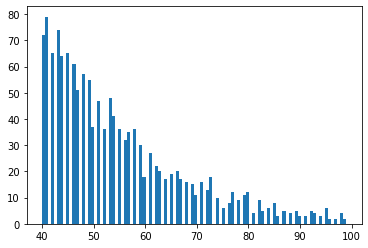

In [456]:
plt.hist(np.array(x_len)[np.array(x_len) < 100], bins = 100)

In [ ]:
y_data[2900:]

In [277]:
batch_size = 256
sequence_length = 35

In [278]:
generator = batch_generator_multi(batch_size=batch_size, sequence_length=sequence_length)
cnnx_batch, y_batch = next(generator)

In [279]:
cnnx_batch[0].shape

(256, 35, 2)

In [ ]:
print(x_batch.shape)
print(y_batch.shape)

In [ ]:
y_batch

In [225]:
validation_data = (np.expand_dims(x_test, axis =0),
                   np.expand_dims(y_test, axis=0))

In [211]:
validation_data = ([np.expand_dims(x_test[:,0:2], axis=0).reshape(1,2,-1,1), np.expand_dims(x_test, axis =0)],
                   np.expand_dims(y_test, axis=0))

In [457]:
validation_data = ([np.expand_dims(x_test[:,0:2], axis=0), np.expand_dims(x_test[:,2:], axis =0)],
                   np.expand_dims(y_test, axis=0))

In [439]:
validation_data[0][0].shape

(1, 4588, 2)

In [ ]:
validation_data[1]

In [75]:
num_steps = 50
lats = 128
lons = 128
features = 4
out_feats = 3

model = Sequential()
model.add(TimeDistributed(Conv1D(16, (3), activation='relu', padding='same'), 
                          input_shape=(num_steps, lats, features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=(2))))
model.add(TimeDistributed(Conv1D(32, (3), activation='relu', padding='same')))
model.add(TimeDistributed(MaxPooling1D(pool_size=(2))))
model.add(TimeDistributed(Conv1D(32, (3), activation='relu', padding='same')))
model.add(TimeDistributed(MaxPooling1D(pool_size=(2))))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(units=64, return_sequences=True))


In [ ]:
model.summary()

In [97]:
cnn_input = Input(shape=(2, 30,1), dtype='float', name='cnn_input')
CNN_out = (TimeDistributed(Conv1D(16, (3), activation='relu', padding='same')))(cnn_input)

CNN_out = (TimeDistributed(MaxPooling1D(pool_size=(2), strides=None, padding='valid')))(CNN_out)
# CNN_out = Permute(dims = (2,3,1))(CNN_out)
CNN_out = (TimeDistributed(Flatten()))(CNN_out)
# CNN_out = Permute(dims = (2,1))(CNN_out)
cnn = Model(inputs=cnn_input, outputs=CNN_out)

In [541]:
cnn_input = Input(shape=(None,2), dtype='float', name='cnn_input')
CNN_out = Lambda(lambda x: expand_dims(x, -1))(cnn_input)
CNN_out = (TimeDistributed(Dense(8, activation = 'tanh')))(CNN_out)
# CNN_out = (TimeDistributed(Conv1D(16, (16), activation='tanh', padding='same')))(CNN_out)
# CNN_out = (TimeDistributed(MaxPooling1D(pool_size=(2), strides=None, padding='valid')))(CNN_out)
CNN_out = (TimeDistributed(Conv1D(16, (20), activation='elu', padding='same')))(CNN_out)
CNN_out = (TimeDistributed(MaxPooling1D(pool_size=(1), strides=None, padding='valid')))(CNN_out)
# CNN_out = Permute(dims = (2,3,1))(CNN_out)
CNN_out = (TimeDistributed(Flatten()))(CNN_out)
# CNN_out = (TimeDistributed(Dense(4)))(CNN_out)
# CNN_out = Permute(dims = (2,1))(CNN_out)
# CNN_out = (Lambda(lambda x: squeeze(x, -1)))(CNN_out)
cnn = Model(inputs=cnn_input, outputs=CNN_out)

In [92]:
cnn_input = Input(shape=(30,2), dtype='float', name='cnn_input')
CNN_out = Dense(16)(cnn_input)
CNN_out = (Conv1D(2, (6), activation='relu', padding='same'))(cnn_input)
# CNN_out = (Conv1D(16, (15), activation='relu', padding='same'))(CNN_out)
CNN_out = (MaxPooling1D(pool_size=(3), strides=None, padding='valid'))(CNN_out)
# CNN_out = (Flatten())(CNN_out)
cnn = Model(inputs=cnn_input, outputs=CNN_out)

In [354]:
cnn.summary()

Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cnn_input (InputLayer)       [(None, None, 2)]         0         
_________________________________________________________________
lambda_15 (Lambda)           (None, None, 2, 1)        0         
_________________________________________________________________
time_distributed_88 (TimeDis (None, None, 2, 12)       24        
_________________________________________________________________
time_distributed_89 (TimeDis (None, None, 2, 8)        968       
_________________________________________________________________
time_distributed_90 (TimeDis (None, None, 1, 8)        0         
_________________________________________________________________
time_distributed_91 (TimeDis (None, None, 8)           0         
Total params: 992
Trainable params: 992
Non-trainable params: 0
____________________________________________________________

In [172]:
def layer_clip(input, maxx, minn):
    return K.clip(input, minn, maxx)

In [84]:
aux_input = Input(shape=(None,28), name='aux_input')
x = GRU(50, return_sequences = True, activation = 'tanh')(aux_input)
# x = Dropout(0.5)(x)
x = GRU(38,return_sequences = True, activation = 'tanh')(x)
# x = Dropout(0.01)(x)
x = GRU(24,return_sequences = True, activation = 'tanh')(x)
# x = Dropout(0.2)(x)
# x = concatenate([CNN_out, x], axis = 2)
# x = Dense(30, activation = 'elu')(x)
main_output = Dense(1, name='main_output')(x)
# x = Dense(1, name='main_output')(x)
# main_output = ELU(alpha = 1.5)(x)
# main_output = Lambda(lambda x: K.clip(x, -1.0,1.0))(x)
# model = Model(inputs= [cnn_input,aux_input], outputs=[main_output])
model = Model(inputs= aux_input, outputs=[main_output])

In [ ]:
aux_input = Input(shape=(None,26), name='aux_input')
x = GRU(40, return_sequences = True, activation = 'tanh')(aux_input)
# x = Dropout(0.5)(x)
x = GRU(20,return_sequences = True, activation = 'tanh')(x)
# x = Dropout(0.01)(x)
# x = GRU(24,return_sequences = True, activation = 'tanh')(x)
# x = Dropout(0.2)(x)
x = concatenate([CNN_out, x], axis = 2)
# x = Dense(30, activation = 'elu')(x)
main_output = Dense(1, name='main_output')(x)
# x = Dense(1, name='main_output')(x)
# main_output = ELU(alpha = 1.5)(x)
# main_output = Lambda(lambda x: K.clip(x, -1.0,1.0))(x)
model = Model(inputs= [cnn_input,aux_input], outputs=[main_output])
# model = Model(inputs= aux_input, outputs=[main_output])

In [85]:
auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(CNN_out)

In [542]:
auxiliary_input = Input(shape=(None,26), name='aux_input')
x = concatenate([CNN_out, auxiliary_input], axis = 2)

In [543]:
x = GRU(80, return_sequences = True, activation = 'tanh')(x)
x = Dropout(0.05)(x)
# x = GRU(38,return_sequences = True, activation = 'tanh')(x)
# x = GRU(24,return_sequences = True, activation = 'elu')(x)
# x = Dropout(0.1)(x)
# x = Dropout(0.2)(x)
main_output = Dense(1, name='main_output')(x)
model = Model(inputs=[cnn_input, auxiliary_input], outputs=[main_output])


In [544]:
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])

In [545]:
model.summary()

Model: "model_66"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn_input (InputLayer)          [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
lambda_28 (Lambda)              (None, None, 2, 1)   0           cnn_input[0][0]                  
__________________________________________________________________________________________________
time_distributed_140 (TimeDistr (None, None, 2, 8)   16          lambda_28[0][0]                  
__________________________________________________________________________________________________
time_distributed_141 (TimeDistr (None, None, 2, 16)  2576        time_distributed_140[0][0]       
___________________________________________________________________________________________

In [340]:
from IPython.display import SVG
from tensorflow.python.keras.utils import model_to_dot

In [311]:
model_to_dot(model)

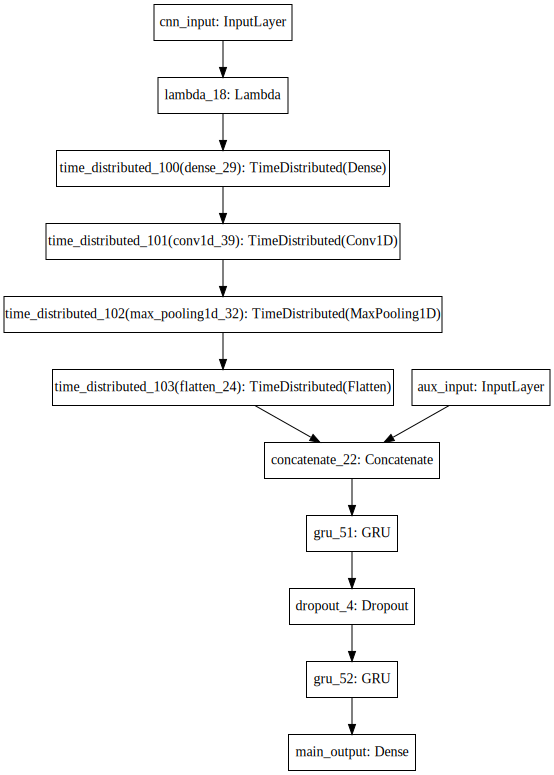

In [417]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [109]:
%load_ext tensorboard
!rm -rf ./logs/ 

In [110]:
# import datetime
# log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [546]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

0.05
0.1
0.2
Epoch 00041: early stopping
0.3
Epoch 00043: early stopping
0.4
Epoch 00047: early stopping


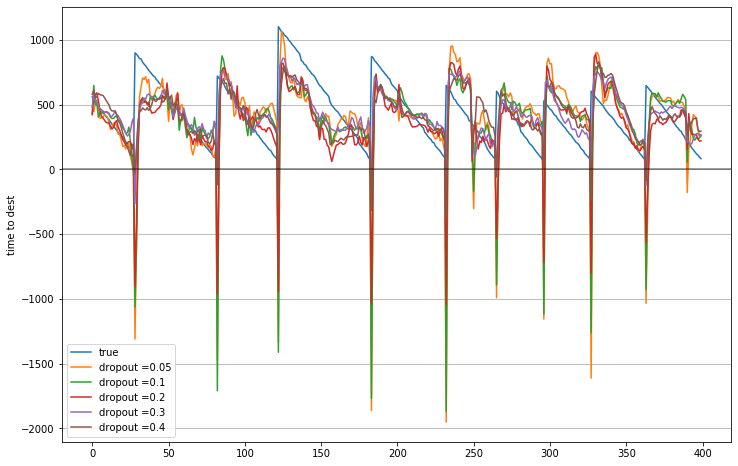

In [540]:
# batch_size = [40,80,120]
num_units = [18,19,20,21,22]
drop_rate = [0.05,0.1,0.2,0.3, 0.4]
plt.figure(figsize=(12, 8))
plt.plot(y_test_rescaled[1100:1500], label = 'true')
for i, j in enumerate(drop_rate):
    print(j)
    generator = batch_generator_multi(batch_size=batch_size, sequence_length=sequence_length)
    
    path_checkpoint = '23_checkpoint.keras'
    callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                          monitor='val_loss',
                                          verbose=0,
                                          save_weights_only=True,
                                          save_best_only=True)
    callback_early_stopping = EarlyStopping(monitor='val_loss',
                                            patience=5, verbose=1)
    callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                       histogram_freq=0,
                                       write_graph=False)
    callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                           factor=0.1,
                                           min_lr=1e-4,
                                           patience=0,
                                           verbose=0)

    callbacks = [callback_early_stopping,
                 callback_checkpoint,
                 callback_tensorboard,
                 callback_reduce_lr]
    
    cnn_input = Input(shape=(None,2), dtype='float', name='cnn_input')
    CNN_out = Lambda(lambda x: expand_dims(x, -1))(cnn_input)
    CNN_out = (TimeDistributed(Dense(8, activation = 'tanh')))(CNN_out)
    # CNN_out = (TimeDistributed(Conv1D(16, (16), activation='tanh', padding='same')))(CNN_out)
    # CNN_out = (TimeDistributed(MaxPooling1D(pool_size=(2), strides=None, padding='valid')))(CNN_out)
    CNN_out = (TimeDistributed(Conv1D(16, (20), activation='elu', padding='same')))(CNN_out)
    CNN_out = (TimeDistributed(MaxPooling1D(pool_size=(1), strides=None, padding='valid')))(CNN_out)
    # CNN_out = Permute(dims = (2,3,1))(CNN_out)
    CNN_out = (TimeDistributed(Flatten()))(CNN_out)
    
    auxiliary_input = Input(shape=(None,26), name='aux_input')
    x = concatenate([CNN_out, auxiliary_input], axis = 2)

    aux_input = Input(shape=(None,26), name='aux_input')
    x = GRU(60, return_sequences = True, activation = 'tanh')(aux_input)
    x = Dropout(j)(x)
#     x = GRU(20,return_sequences = True, activation = 'tanh')(x)
    main_output = Dense(1, name='main_output')(x)

    model = Model(inputs= [cnn_input, aux_input], outputs=[main_output])
    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
    model.fit_generator(generator=generator,
                        epochs=50,
                        steps_per_epoch=50,
                        validation_data=validation_data,
                        callbacks=callbacks,
                       verbose = 0)
    try:
        model.load_weights(path_checkpoint)
    except Exception as error:
        print("Error trying to load checkpoint.")
        print(error)
#     y_pred = model.predict(np.expand_dims(x_test, axis =0))
    y_pred = model.predict([np.expand_dims(x_test[:,0:2], axis=0), np.expand_dims(x_test[:,2:], axis =0)])

    y_pred_rescaled = scy.inverse_transform(y_pred[0])
    y_test_rescaled = scy.inverse_transform(y_test)

#     plt.figure(figsize=(12, 8))
    plt.ylabel('time to dest')
    # plt.plot(y_pred_rescaled, label = 'pred')
    # plt.plot(y_test_rescaled, label = 'true')
    plt.plot(y_pred_rescaled[1100:1500], label = 'dropout =' + str(j))

#     plt.plot(y_test_rescaled[1400:2000], label = 'true')
#     plt.legend()
plt.grid(axis = 'y')
plt.axhline(0, color='black',alpha = 0.5)
plt.legend() 
plt.show()

Epoch 1/50
199/200 [============================>.] - ETA: 0s - loss: 0.1293 - mean_absolute_error: 0.1293
Epoch 00001: val_loss improved from inf to 0.06076, saving model to 23_checkpoint.keras
200/200 [==============================] - 34s 172ms/step - loss: 0.1289 - mean_absolute_error: 0.1289 - val_loss: 0.0608 - val_mean_absolute_error: 0.0608
Epoch 2/50
199/200 [============================>.] - ETA: 0s - loss: 0.0392 - mean_absolute_error: 0.0392
Epoch 00002: val_loss improved from 0.06076 to 0.04688, saving model to 23_checkpoint.keras
200/200 [==============================] - 19s 94ms/step - loss: 0.0391 - mean_absolute_error: 0.0391 - val_loss: 0.0469 - val_mean_absolute_error: 0.0469
Epoch 3/50
199/200 [============================>.] - ETA: 0s - loss: 0.0298 - mean_absolute_error: 0.0298
Epoch 00003: val_loss did not improve from 0.04688

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
200/200 [==============================] - 22s 109ms/st

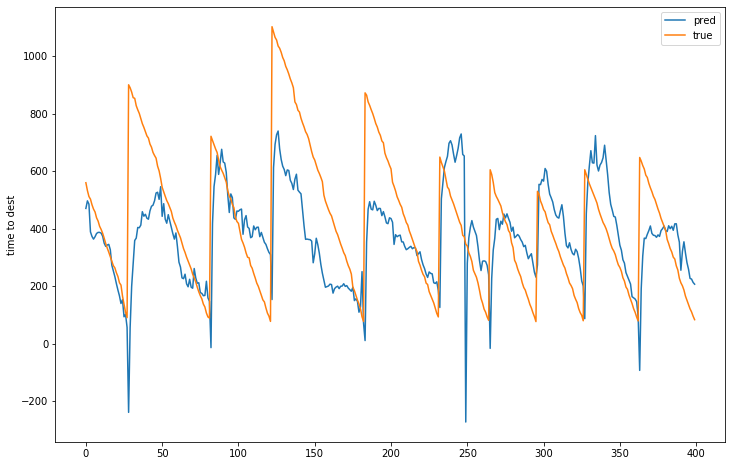

In [547]:
model.fit_generator(generator=generator,
                    epochs=50,
                    steps_per_epoch=200,
                    validation_data=validation_data,
                    callbacks=callbacks)
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)
# y_pred = model.predict(np.expand_dims(x_test, axis =0))
y_pred = model.predict([np.expand_dims(x_test[:,0:2], axis=0), np.expand_dims(x_test[:,2:], axis =0)])
# y_pred = model.predict([np.expand_dims(x_test[:,0:2], axis=0), np.expand_dims(x_test, axis =0)])

y_pred_rescaled = scy.inverse_transform(y_pred[0])
y_test_rescaled = scy.inverse_transform(y_test)

plt.figure(figsize=(12, 8))
plt.ylabel('time to dest')
# plt.plot(y_pred_rescaled, label = 'pred')
# plt.plot(y_test_rescaled, label = 'true')
plt.plot(y_pred_rescaled[1100:1500], label = 'pred')
plt.plot(y_test_rescaled[1100:1500], label = 'true')
plt.legend()

In [557]:
model.save('cnnrnn_080920')

In [559]:
model = []

In [560]:
model = tf.keras.models.load_model('cnnrnn_080920')

In [999]:
import gc
gc.collect()

4651

In [1153]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [ ]:
result = model.evaluate(x=[np.expand_dims(x_test[:,0:2], axis=0).reshape(1,-1,2,1), np.expand_dims(x_test, axis =0)],
                        y=np.expand_dims(y_test, axis=0))

In [83]:
y_pred = model.predict(np.expand_dims(x_test, axis =0))

In [565]:
y_pred = np.clip(y_pred,-1.0,1.0)

In [894]:
y_pred = model.predict([np.expand_dims(x_test[:,0:2], axis=0).reshape(1,2,-1,1), np.expand_dims(x_test, axis =0)])

In [ ]:
y_pred = model.predict([np.expand_dims(x_test[:,0:2], axis=0), np.expand_dims(x_test, axis =0)])

In [561]:
y_pred = model.predict([np.expand_dims(x_test[:,0:2], axis=0), np.expand_dims(x_test[:,2:], axis =0)])


In [567]:
y_pred_rescaled = scy.inverse_transform(y_pred[0])
y_test_rescaled = scy.inverse_transform(y_test)

In [550]:
y_pred[0][y_pred[0]> 1]

array([], dtype=float32)

In [ ]:
scy.inverse_transform(y_pred[0][y_pred[0] < -1].reshape(1,-1))

In [551]:
y_pred

array([[[-0.9299374 ],
        [-0.9196684 ],
        [-0.92903215],
        ...,
        [-0.97776616],
        [-0.9805847 ],
        [-0.9820197 ]]], dtype=float32)

In [552]:
y_pred_rescaled 

array([[824.4643 ],
       [934.31256],
       [834.1481 ],
       ...,
       [312.83914],
       [282.68933],
       [267.33865]], dtype=float32)

In [553]:
y_test_rescaled 

array([[858.21010257],
       [845.10092854],
       [827.26115325],
       ...,
       [140.36183974],
       [126.39463374],
       [109.56029494]])

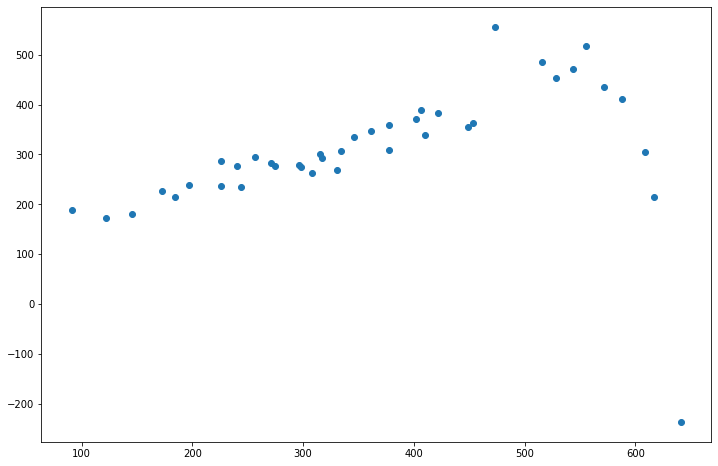

In [563]:
plt.figure(figsize=(12, 8))
plt.scatter(y_test_rescaled[120:160] , y_pred_rescaled[120:160])


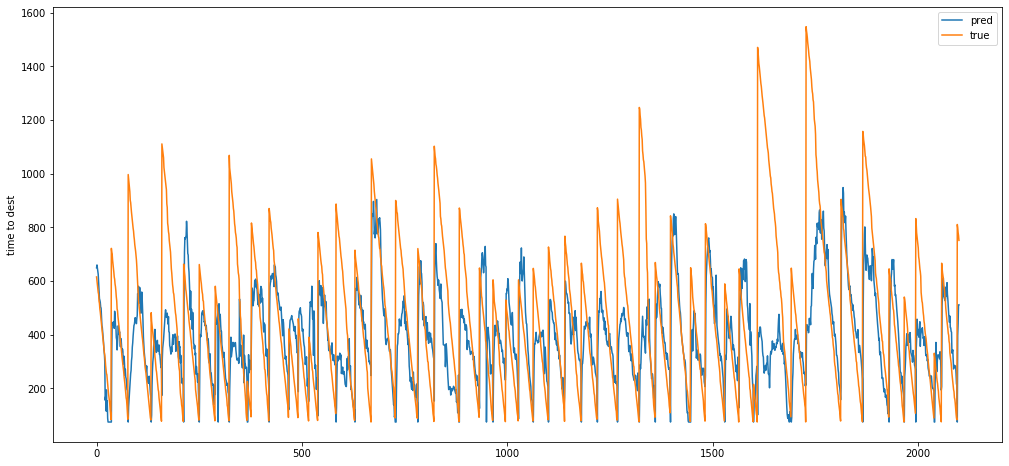

In [568]:
plt.figure(figsize=(17, 8))
plt.ylabel('time to dest')
# plt.plot(y_pred_rescaled, label = 'pred')
# plt.plot(y_test_rescaled, label = 'true')
plt.plot(y_pred_rescaled[400:2500], label = 'pred')
plt.plot(y_test_rescaled[400:2500], label = 'true')
plt.legend()

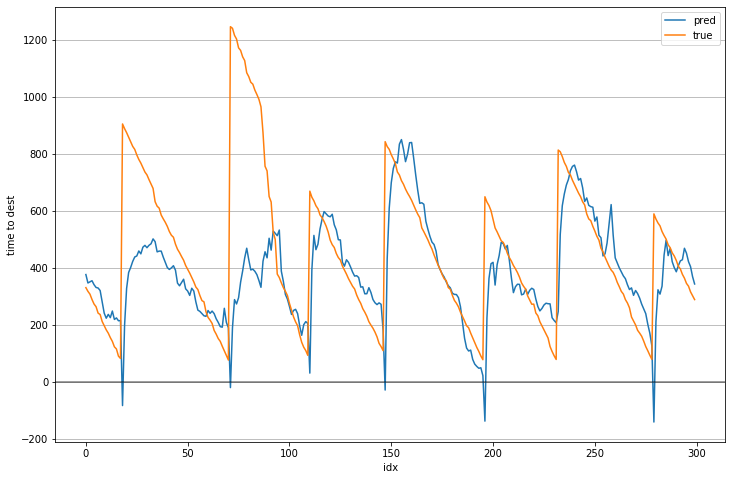

In [556]:
plt.figure(figsize=(12, 8))
plt.ylabel('time to dest')
plt.xlabel('idx')

plt.plot(y_pred_rescaled[1650:1950], label = 'pred')
plt.plot(y_test_rescaled[1650:1950], label = 'true')
plt.grid(axis = 'y')
plt.axhline(0, color='black',alpha = 0.5)
plt.legend()

### x

In [161]:
from sklearn.metrics import mean_absolute_error

In [325]:
mean_absolute_error(y_test_rescaled , y_pred_rescaled )

254.3194663760776